# Exploratory Data Analysis (EDA) for CS10 Satellite Image Classification

This notebook performs comprehensive exploratory data analysis to inform CNN model design and training strategy.

In [1]:
# Import essential libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import defaultdict, Counter
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 1. DATASET OVERVIEW

In [2]:
# Configure dataset paths
BASE_DIR = Path(r"c:\Users\Hyper\Documents\Personal\Hackathons\2025_HacX_Hackathon\frontend\HacX")
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"

CLASSES = ['normal', 'haze', 'smoke']
CLASS_COLORS = {'normal': '#2ecc71', 'haze': '#f39c12', 'smoke': '#e74c3c'}

print(f"Base Directory: {BASE_DIR}")
print(f"Train Directory: {TRAIN_DIR}")
print(f"Test Directory: {TEST_DIR}")

Base Directory: c:\Users\Hyper\Documents\Personal\Hackathons\2025_HacX_Hackathon\frontend\HacX
Train Directory: c:\Users\Hyper\Documents\Personal\Hackathons\2025_HacX_Hackathon\frontend\HacX\train
Test Directory: c:\Users\Hyper\Documents\Personal\Hackathons\2025_HacX_Hackathon\frontend\HacX\test


In [3]:
def load_dataset_info(data_dir, classes):
    """
    Load image file paths and count samples per class.
    
    Args:
        data_dir: Path to the dataset directory
        classes: List of class names
    
    Returns:
        Dictionary with class names as keys and lists of image paths as values
    """
    dataset_info = {cls: [] for cls in classes}
    
    for cls in classes:
        class_dir = data_dir / cls
        if class_dir.exists():
            # Get all image files (common extensions)
            image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif']
            for ext in image_extensions:
                dataset_info[cls].extend(list(class_dir.glob(f'*{ext}')))
                dataset_info[cls].extend(list(class_dir.glob(f'*{ext.upper()}')))
    
    return dataset_info

# Load training and test datasets
train_data = load_dataset_info(TRAIN_DIR, CLASSES)
test_data = load_dataset_info(TEST_DIR, CLASSES)

# Count samples per class
train_counts = {cls: len(paths) for cls, paths in train_data.items()}
test_counts = {cls: len(paths) for cls, paths in test_data.items()}

# Create summary DataFrame
df_summary = pd.DataFrame({
    'Class': CLASSES,
    'Train Samples': [train_counts[cls] for cls in CLASSES],
    'Test Samples': [test_counts[cls] for cls in CLASSES],
})
df_summary['Total'] = df_summary['Train Samples'] + df_summary['Test Samples']
df_summary['Train %'] = (df_summary['Train Samples'] / df_summary['Train Samples'].sum() * 100).round(2)

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(df_summary.to_string(index=False))
print("="*60)
print(f"Total Training Samples: {df_summary['Train Samples'].sum()}")
print(f"Total Test Samples: {df_summary['Test Samples'].sum()}")
print(f"Total Samples: {df_summary['Total'].sum()}")
print("="*60)


DATASET SUMMARY
 Class  Train Samples  Test Samples  Total  Train %
normal           5048          1682   6730    67.60
  haze           1202           400   1602    16.10
 smoke           1218           406   1624    16.31
Total Training Samples: 7468
Total Test Samples: 2488
Total Samples: 9956


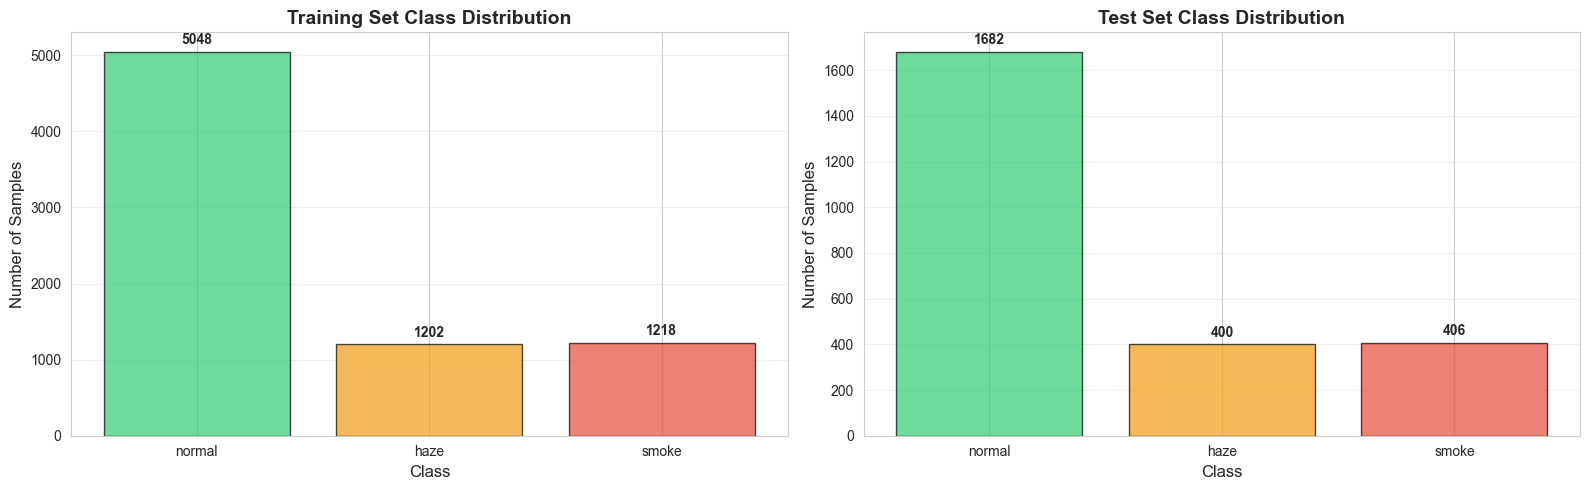

In [16]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training set distribution
axes[0].bar(CLASSES, [train_counts[cls] for cls in CLASSES], 
           color=[CLASS_COLORS[cls] for cls in CLASSES], alpha=0.7, edgecolor='black')
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, cls in enumerate(CLASSES):
    axes[0].text(i, train_counts[cls] + max(train_counts.values())*0.02, 
                str(train_counts[cls]), ha='center', fontweight='bold')

# Test set distribution
axes[1].bar(CLASSES, [test_counts[cls] for cls in CLASSES], 
           color=[CLASS_COLORS[cls] for cls in CLASSES], alpha=0.7, edgecolor='black')
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, cls in enumerate(CLASSES):
    axes[1].text(i, test_counts[cls] + max(test_counts.values())*0.02, 
                str(test_counts[cls]), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
# Check for class imbalance
def analyze_class_balance(counts, threshold=0.15):
    """
    Analyze class imbalance and recommend strategies.
    
    Args:
        counts: Dictionary of class counts
        threshold: Imbalance threshold (default 15%)
    """
    total = sum(counts.values())
    proportions = {cls: count/total for cls, count in counts.items()}
    
    max_prop = max(proportions.values())
    min_prop = min(proportions.values())
    imbalance_ratio = max_prop / min_prop
    
    print("\n" + "="*60)
    print("CLASS BALANCE ANALYSIS")
    print("="*60)
    
    for cls, prop in proportions.items():
        print(f"{cls:10s}: {prop*100:5.2f}% ({counts[cls]:4d} samples)")
    
    print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 1.5:
        print("\n⚠️  MODERATE TO SEVERE CLASS IMBALANCE DETECTED")
        print("\n🔧 RECOMMENDED STRATEGIES:")
        print("   1. Class Weights: Assign higher weights to minority classes")
        print("      - Use sklearn.utils.class_weight.compute_class_weight")
        print("      - Apply in loss function (weighted cross-entropy)")
        print("   2. Focal Loss: Focus training on hard examples")
        print("      - Better than standard cross-entropy for imbalanced data")
        print("   3. Augmentation: Apply more aggressive augmentation to minority classes")
        print("   4. SMOTE/Oversampling: Synthetically oversample minority classes")
        print("   5. Stratified Sampling: Ensure balanced batches during training")
    elif imbalance_ratio > 1.2:
        print("\n⚠️  MILD CLASS IMBALANCE DETECTED")
        print("\n🔧 RECOMMENDED STRATEGIES:")
        print("   1. Class Weights: Apply moderate weighting")
        print("   2. Stratified Sampling: Use stratified batches")
    else:
        print("\n✓ CLASSES ARE WELL BALANCED")
        print("   - Standard cross-entropy loss should work well")
    
    print("="*60)
    
    return proportions, imbalance_ratio

# Analyze training set balance
train_props, train_imbalance = analyze_class_balance(train_counts)


CLASS BALANCE ANALYSIS
normal    : 67.60% (5048 samples)
haze      : 16.10% (1202 samples)
smoke     : 16.31% (1218 samples)

Imbalance Ratio: 4.20:1

⚠️  MODERATE TO SEVERE CLASS IMBALANCE DETECTED

🔧 RECOMMENDED STRATEGIES:
   1. Class Weights: Assign higher weights to minority classes
      - Use sklearn.utils.class_weight.compute_class_weight
      - Apply in loss function (weighted cross-entropy)
   2. Focal Loss: Focus training on hard examples
      - Better than standard cross-entropy for imbalanced data
   3. Augmentation: Apply more aggressive augmentation to minority classes
   4. SMOTE/Oversampling: Synthetically oversample minority classes
   5. Stratified Sampling: Ensure balanced batches during training


## 2. IMAGE CHARACTERISTICS ANALYSIS

In [ ]:
def analyze_image_properties(data_dict, sample_size=None):
    """
    Analyze image dimensions, aspect ratios, and color channels.
    
    Args:
        data_dict: Dictionary with class names and image paths
        sample_size: Number of images to sample per class (None for all)
    
    Returns:
        DataFrame with image properties
    """
    properties = []
    
    for cls, img_paths in data_dict.items():
        paths_to_analyze = img_paths if sample_size is None else random.sample(img_paths, min(sample_size, len(img_paths)))
        
        for img_path in paths_to_analyze:
            try:
                img = Image.open(img_path)
                width, height = img.size
                channels = len(img.getbands())
                mode = img.mode
                
                properties.append({
                    'class': cls,
                    'width': width,
                    'height': height,
                    'channels': channels,
                    'mode': mode,
                    'aspect_ratio': width / height,
                    'total_pixels': width * height
                })
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return pd.DataFrame(properties)

# Analyze training images (sample for speed if dataset is large)
print("Analyzing image properties...")
df_props = analyze_image_properties(train_data, sample_size=100)  # Sample 100 per class for speed

print("\n" + "="*60)
print("IMAGE PROPERTIES SUMMARY")
print("="*60)

# Overall statistics
print("\n📊 DIMENSIONS:")
print(f"   Width  - Min: {df_props['width'].min()}, Max: {df_props['width'].max()}, Mean: {df_props['width'].mean():.1f}")
print(f"   Height - Min: {df_props['height'].min()}, Max: {df_props['height'].max()}, Mean: {df_props['height'].mean():.1f}")

print("\n📊 ASPECT RATIOS:")
print(f"   Min: {df_props['aspect_ratio'].min():.3f}")
print(f"   Max: {df_props['aspect_ratio'].max():.3f}")
print(f"   Mean: {df_props['aspect_ratio'].mean():.3f}")

print("\n📊 COLOR MODES:")
print(df_props['mode'].value_counts().to_string())

print("\n📊 CHANNELS:")
print(df_props['channels'].value_counts().to_string())

# Per-class statistics
print("\n" + "="*60)
print("PER-CLASS STATISTICS")
print("="*60)
for cls in CLASSES:
    cls_data = df_props[df_props['class'] == cls]
    print(f"\n{cls.upper()}:")
    print(f"   Samples analyzed: {len(cls_data)}")
    print(f"   Width:  {cls_data['width'].mean():.1f} ± {cls_data['width'].std():.1f}")
    print(f"   Height: {cls_data['height'].mean():.1f} ± {cls_data['height'].std():.1f}")
    print(f"   Aspect Ratio: {cls_data['aspect_ratio'].mean():.3f} ± {cls_data['aspect_ratio'].std():.3f}")

print("="*60)

In [ ]:
# Visualize dimension distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Width distribution
for cls in CLASSES:
    cls_data = df_props[df_props['class'] == cls]
    axes[0, 0].hist(cls_data['width'], bins=30, alpha=0.5, label=cls, color=CLASS_COLORS[cls])
axes[0, 0].set_title('Width Distribution by Class', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
for cls in CLASSES:
    cls_data = df_props[df_props['class'] == cls]
    axes[0, 1].hist(cls_data['height'], bins=30, alpha=0.5, label=cls, color=CLASS_COLORS[cls])
axes[0, 1].set_title('Height Distribution by Class', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution
for cls in CLASSES:
    cls_data = df_props[df_props['class'] == cls]
    axes[1, 0].hist(cls_data['aspect_ratio'], bins=30, alpha=0.5, label=cls, color=CLASS_COLORS[cls])
axes[1, 0].set_title('Aspect Ratio Distribution by Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (width/height)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Total pixels distribution
for cls in CLASSES:
    cls_data = df_props[df_props['class'] == cls]
    axes[1, 1].hist(cls_data['total_pixels']/1e6, bins=30, alpha=0.5, label=cls, color=CLASS_COLORS[cls])
axes[1, 1].set_title('Image Size Distribution by Class', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Total Pixels (Megapixels)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check for inconsistencies
width_std = df_props['width'].std()
height_std = df_props['height'].std()

print("\n⚠️  INCONSISTENCY CHECK:")
if width_std > 100 or height_std > 100:
    print(f"   WARNING: High variation in dimensions detected!")
    print(f"   Width std: {width_std:.1f}, Height std: {height_std:.1f}")
    print("\n   🔧 RECOMMENDATION: Resize all images to a consistent size")
    print(f"   Suggested target size: {int(df_props['width'].median())}x{int(df_props['height'].median())}")
else:
    print("   ✓ Dimensions are relatively consistent across images")

In [ ]:
def compute_rgb_statistics(data_dict, sample_size=50):
    """
    Compute RGB channel statistics per class.
    
    Args:
        data_dict: Dictionary with class names and image paths
        sample_size: Number of images to sample per class
    
    Returns:
        Dictionary with mean and std for each channel per class
    """
    stats = {}
    
    for cls, img_paths in data_dict.items():
        paths_to_analyze = random.sample(img_paths, min(sample_size, len(img_paths)))
        
        all_pixels = {'R': [], 'G': [], 'B': []}
        
        for img_path in paths_to_analyze:
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)
                
                # Sample pixels (to avoid memory issues)
                h, w = img_array.shape[:2]
                sample_pixels = img_array[::max(1, h//100), ::max(1, w//100), :]
                
                all_pixels['R'].extend(sample_pixels[:, :, 0].flatten())
                all_pixels['G'].extend(sample_pixels[:, :, 1].flatten())
                all_pixels['B'].extend(sample_pixels[:, :, 2].flatten())
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        
        stats[cls] = {
            'R_mean': np.mean(all_pixels['R']),
            'R_std': np.std(all_pixels['R']),
            'G_mean': np.mean(all_pixels['G']),
            'G_std': np.std(all_pixels['G']),
            'B_mean': np.mean(all_pixels['B']),
            'B_std': np.std(all_pixels['B']),
        }
    
    return stats

# Compute RGB statistics
print("Computing RGB channel statistics (this may take a moment)...")
rgb_stats = compute_rgb_statistics(train_data, sample_size=50)

# Display results
print("\n" + "="*60)
print("RGB CHANNEL STATISTICS (for normalization)")
print("="*60)
for cls in CLASSES:
    print(f"\n{cls.upper()}:")
    print(f"   R: μ={rgb_stats[cls]['R_mean']:.2f}, σ={rgb_stats[cls]['R_std']:.2f}")
    print(f"   G: μ={rgb_stats[cls]['G_mean']:.2f}, σ={rgb_stats[cls]['G_std']:.2f}")
    print(f"   B: μ={rgb_stats[cls]['B_mean']:.2f}, σ={rgb_stats[cls]['B_std']:.2f}")

# Compute global statistics
global_R_mean = np.mean([rgb_stats[cls]['R_mean'] for cls in CLASSES])
global_G_mean = np.mean([rgb_stats[cls]['G_mean'] for cls in CLASSES])
global_B_mean = np.mean([rgb_stats[cls]['B_mean'] for cls in CLASSES])
global_R_std = np.mean([rgb_stats[cls]['R_std'] for cls in CLASSES])
global_G_std = np.mean([rgb_stats[cls]['G_std'] for cls in CLASSES])
global_B_std = np.mean([rgb_stats[cls]['B_std'] for cls in CLASSES])

print("\n" + "="*60)
print("GLOBAL STATISTICS (recommended for normalization):")
print("="*60)
print(f"Mean: [{global_R_mean/255:.4f}, {global_G_mean/255:.4f}, {global_B_mean/255:.4f}]")
print(f"Std:  [{global_R_std/255:.4f}, {global_G_std/255:.4f}, {global_B_std/255:.4f}]")
print("\n💡 Use these values for input normalization in your CNN")
print("="*60)

In [ ]:
# Plot RGB intensity distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

channels = ['R', 'G', 'B']
channel_names = ['Red', 'Green', 'Blue']

for idx, (ch, ch_name) in enumerate(zip(channels, channel_names)):
    means = [rgb_stats[cls][f'{ch}_mean'] for cls in CLASSES]
    stds = [rgb_stats[cls][f'{ch}_std'] for cls in CLASSES]
    
    x = np.arange(len(CLASSES))
    axes[idx].bar(x, means, yerr=stds, alpha=0.7, 
                  color=[CLASS_COLORS[cls] for cls in CLASSES],
                  edgecolor='black', capsize=5)
    axes[idx].set_title(f'{ch_name} Channel Intensity', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Pixel Intensity (0-255)')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(CLASSES)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim(0, 255)

plt.tight_layout()
plt.show()

## 3. VISUAL INSPECTION

In [ ]:
def display_sample_grid(data_dict, samples_per_class=5, figsize=(18, 10)):
    """
    Display a grid of sample images from each class.
    
    Args:
        data_dict: Dictionary with class names and image paths
        samples_per_class: Number of samples to display per class
        figsize: Figure size
    """
    fig, axes = plt.subplots(len(CLASSES), samples_per_class, figsize=figsize)
    
    for row_idx, cls in enumerate(CLASSES):
        # Randomly sample images
        sample_paths = random.sample(data_dict[cls], min(samples_per_class, len(data_dict[cls])))
        
        for col_idx, img_path in enumerate(sample_paths):
            try:
                img = Image.open(img_path).convert('RGB')
                axes[row_idx, col_idx].imshow(img)
                axes[row_idx, col_idx].axis('off')
                
                if col_idx == 0:
                    axes[row_idx, col_idx].set_ylabel(cls.upper(), 
                                                       fontsize=12, 
                                                       fontweight='bold',
                                                       rotation=0, 
                                                       labelpad=40,
                                                       va='center')
            except Exception as e:
                print(f"Error displaying {img_path}: {e}")
    
    plt.suptitle('Random Sample Images from Each Class', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Display sample grid
print("Displaying sample images...")
display_sample_grid(train_data, samples_per_class=5)

In [ ]:
def apply_edge_detection(data_dict, samples_per_class=3):
    """
    Apply Canny edge detection to assess texture separability.
    
    Args:
        data_dict: Dictionary with class names and image paths
        samples_per_class: Number of samples to process per class
    """
    fig, axes = plt.subplots(len(CLASSES), samples_per_class * 2, figsize=(18, 10))
    
    for row_idx, cls in enumerate(CLASSES):
        sample_paths = random.sample(data_dict[cls], min(samples_per_class, len(data_dict[cls])))
        
        for col_idx, img_path in enumerate(sample_paths):
            try:
                # Load and convert to grayscale
                img = cv2.imread(str(img_path))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Apply Canny edge detection
                edges = cv2.Canny(img_gray, 50, 150)
                
                # Display original
                axes[row_idx, col_idx * 2].imshow(img_rgb)
                axes[row_idx, col_idx * 2].axis('off')
                
                # Display edges
                axes[row_idx, col_idx * 2 + 1].imshow(edges, cmap='gray')
                axes[row_idx, col_idx * 2 + 1].axis('off')
                
                if col_idx == 0:
                    axes[row_idx, 0].set_ylabel(cls.upper(), 
                                                fontsize=12, 
                                                fontweight='bold',
                                                rotation=0, 
                                                labelpad=40,
                                                va='center')
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    plt.suptitle('Edge Detection (Canny) - Original vs Edges', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Apply edge detection
print("Applying edge detection...")
apply_edge_detection(train_data, samples_per_class=3)

In [ ]:
def apply_gabor_filters(img_gray, orientations=[0, 45, 90, 135]):
    """
    Apply Gabor filters at different orientations to highlight textures.
    
    Args:
        img_gray: Grayscale image
        orientations: List of filter orientations in degrees
    
    Returns:
        Combined filtered image
    """
    filters = []
    for theta in orientations:
        theta_rad = theta / 180.0 * np.pi
        kernel = cv2.getGaborKernel((21, 21), 5, theta_rad, 10, 0.5, 0, ktype=cv2.CV_32F)
        filtered = cv2.filter2D(img_gray, cv2.CV_8UC3, kernel)
        filters.append(filtered)
    
    # Combine all orientations
    combined = np.max(filters, axis=0)
    return combined

def display_gabor_analysis(data_dict, samples_per_class=2):
    """
    Display Gabor filter analysis for texture detection.
    """
    fig, axes = plt.subplots(len(CLASSES), samples_per_class * 2, figsize=(16, 10))
    
    for row_idx, cls in enumerate(CLASSES):
        sample_paths = random.sample(data_dict[cls], min(samples_per_class, len(data_dict[cls])))
        
        for col_idx, img_path in enumerate(sample_paths):
            try:
                img = cv2.imread(str(img_path))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Apply Gabor filters
                gabor_result = apply_gabor_filters(img_gray)
                
                # Display original
                axes[row_idx, col_idx * 2].imshow(img_rgb)
                axes[row_idx, col_idx * 2].axis('off')
                
                # Display Gabor result
                axes[row_idx, col_idx * 2 + 1].imshow(gabor_result, cmap='hot')
                axes[row_idx, col_idx * 2 + 1].axis('off')
                
                if col_idx == 0:
                    axes[row_idx, 0].set_ylabel(cls.upper(), 
                                                fontsize=12, 
                                                fontweight='bold',
                                                rotation=0, 
                                                labelpad=40,
                                                va='center')
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    plt.suptitle('Gabor Filter Analysis - Original vs Texture Response', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Apply Gabor filter analysis
print("Applying Gabor filter analysis...")
display_gabor_analysis(train_data, samples_per_class=2)

## 4. COLOR & SPECTRAL ANALYSIS

In [ ]:
def extract_color_features(data_dict, sample_size=30, pixels_per_image=1000):
    """
    Extract RGB pixel values from images for color space analysis.
    
    Args:
        data_dict: Dictionary with class names and image paths
        sample_size: Number of images to sample per class
        pixels_per_image: Number of pixels to sample per image
    
    Returns:
        DataFrame with RGB values and class labels
    """
    color_data = []
    
    for cls, img_paths in data_dict.items():
        paths_to_analyze = random.sample(img_paths, min(sample_size, len(img_paths)))
        
        for img_path in paths_to_analyze:
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)
                
                # Flatten and sample pixels
                h, w = img_array.shape[:2]
                pixels = img_array.reshape(-1, 3)
                
                # Random sample
                if len(pixels) > pixels_per_image:
                    indices = np.random.choice(len(pixels), pixels_per_image, replace=False)
                    pixels = pixels[indices]
                
                for pixel in pixels:
                    color_data.append({
                        'class': cls,
                        'R': pixel[0],
                        'G': pixel[1],
                        'B': pixel[2]
                    })
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    return pd.DataFrame(color_data)

# Extract color features
print("Extracting color features for RGB space analysis...")
df_colors = extract_color_features(train_data, sample_size=30, pixels_per_image=500)
print(f"Extracted {len(df_colors)} pixel samples")
print(df_colors.head())

In [ ]:
# Create RGB scatter plots
fig = plt.figure(figsize=(18, 12))

# R vs G
ax1 = fig.add_subplot(2, 3, 1)
for cls in CLASSES:
    cls_data = df_colors[df_colors['class'] == cls].sample(min(1000, len(df_colors[df_colors['class'] == cls])))
    ax1.scatter(cls_data['R'], cls_data['G'], alpha=0.3, s=1, label=cls, color=CLASS_COLORS[cls])
ax1.set_xlabel('Red Channel')
ax1.set_ylabel('Green Channel')
ax1.set_title('R vs G Channel', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# R vs B
ax2 = fig.add_subplot(2, 3, 2)
for cls in CLASSES:
    cls_data = df_colors[df_colors['class'] == cls].sample(min(1000, len(df_colors[df_colors['class'] == cls])))
    ax2.scatter(cls_data['R'], cls_data['B'], alpha=0.3, s=1, label=cls, color=CLASS_COLORS[cls])
ax2.set_xlabel('Red Channel')
ax2.set_ylabel('Blue Channel')
ax2.set_title('R vs B Channel', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# G vs B
ax3 = fig.add_subplot(2, 3, 3)
for cls in CLASSES:
    cls_data = df_colors[df_colors['class'] == cls].sample(min(1000, len(df_colors[df_colors['class'] == cls])))
    ax3.scatter(cls_data['G'], cls_data['B'], alpha=0.3, s=1, label=cls, color=CLASS_COLORS[cls])
ax3.set_xlabel('Green Channel')
ax3.set_ylabel('Blue Channel')
ax3.set_title('G vs B Channel', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 2D density plots
from scipy.stats import gaussian_kde

for idx, cls in enumerate(CLASSES):
    ax = fig.add_subplot(2, 3, 4 + idx)
    cls_data = df_colors[df_colors['class'] == cls].sample(min(2000, len(df_colors[df_colors['class'] == cls])))
    
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(cls_data['R'], cls_data['G'], bins=50)
    ax.imshow(h.T, origin='lower', extent=[0, 255, 0, 255], cmap='hot', aspect='auto')
    ax.set_xlabel('Red Channel')
    ax.set_ylabel('Green Channel')
    ax.set_title(f'{cls.upper()} - R vs G Density', fontweight='bold')

plt.suptitle('RGB Color Space Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# Analyze color space separability
print("\n" + "="*60)
print("COLOR SPACE SEPARABILITY ANALYSIS")
print("="*60)

for cls in CLASSES:
    cls_data = df_colors[df_colors['class'] == cls]
    print(f"\n{cls.upper()}:")
    print(f"   R: {cls_data['R'].mean():.1f} ± {cls_data['R'].std():.1f}")
    print(f"   G: {cls_data['G'].mean():.1f} ± {cls_data['G'].std():.1f}")
    print(f"   B: {cls_data['B'].mean():.1f} ± {cls_data['B'].std():.1f}")
    print(f"   R/G ratio: {(cls_data['R'] / (cls_data['G'] + 1)).mean():.3f}")
    print(f"   B/G ratio: {(cls_data['B'] / (cls_data['G'] + 1)).mean():.3f}")

# Check for overlap
print("\n" + "="*60)
print("OVERLAP ASSESSMENT:")
print("="*60)

# Compute pairwise distance between class centroids in RGB space
centroids = {}
for cls in CLASSES:
    cls_data = df_colors[df_colors['class'] == cls]
    centroids[cls] = np.array([
        cls_data['R'].mean(),
        cls_data['G'].mean(),
        cls_data['B'].mean()
    ])

print("\nCentroid distances in RGB space:")
for i, cls1 in enumerate(CLASSES):
    for cls2 in CLASSES[i+1:]:
        dist = np.linalg.norm(centroids[cls1] - centroids[cls2])
        print(f"   {cls1} <-> {cls2}: {dist:.2f}")

print("\n💡 INSIGHT:")
print("   - Smaller distances indicate more overlap in RGB space")
print("   - Classes with distance < 30 may be hard to separate using color alone")
print("   - Consider texture/spatial features for better discrimination")
print("="*60)

## 5. SPATIAL PATTERNS ANALYSIS

In [ ]:
def compute_average_image(data_dict, target_size=(224, 224), sample_size=50):
    """
    Compute the average image for each class to detect spatial patterns.
    
    Args:
        data_dict: Dictionary with class names and image paths
        target_size: Size to resize images to before averaging
        sample_size: Number of images to use per class
    
    Returns:
        Dictionary with class names and average images
    """
    avg_images = {}
    
    for cls, img_paths in data_dict.items():
        paths_to_use = random.sample(img_paths, min(sample_size, len(img_paths)))
        
        accumulated = np.zeros((*target_size, 3), dtype=np.float32)
        count = 0
        
        for img_path in paths_to_use:
            try:
                img = Image.open(img_path).convert('RGB')
                img_resized = img.resize(target_size)
                img_array = np.array(img_resized, dtype=np.float32)
                accumulated += img_array
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        
        if count > 0:
            avg_images[cls] = (accumulated / count).astype(np.uint8)
    
    return avg_images

# Compute average images
print("Computing average images per class...")
avg_images = compute_average_image(train_data, target_size=(224, 224), sample_size=50)

# Display average images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, cls in enumerate(CLASSES):
    axes[idx].imshow(avg_images[cls])
    axes[idx].set_title(f'{cls.upper()} - Average Image', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Average Images by Class (Pixel-wise Mean)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 SPATIAL PATTERN OBSERVATIONS:")
print("   - Look for consistent patterns in specific regions")
print("   - Haze/smoke might appear more in upper portions (sky)")
print("   - Normal images might have more distinct ground features")
print("   - Consistent patterns suggest positional bias in the dataset")

In [ ]:
# Analyze spatial distribution (where haze/smoke typically appears)
def analyze_spatial_distribution(avg_images):
    """
    Analyze where features concentrate in average images.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for idx, cls in enumerate(CLASSES):
        # Convert to grayscale for intensity analysis
        gray = cv2.cvtColor(avg_images[cls], cv2.COLOR_RGB2GRAY)
        
        # Display grayscale average
        axes[0, idx].imshow(gray, cmap='gray')
        axes[0, idx].set_title(f'{cls.upper()} - Grayscale', fontweight='bold')
        axes[0, idx].axis('off')
        
        # Compute and display vertical profile (average intensity per row)
        vertical_profile = gray.mean(axis=1)
        horizontal_profile = gray.mean(axis=0)
        
        # Horizontal profile plot (top to bottom)
        axes[1, idx].plot(vertical_profile, range(len(vertical_profile)), linewidth=2, color=CLASS_COLORS[cls])
        axes[1, idx].set_title(f'{cls.upper()} - Vertical Intensity Profile', fontweight='bold')
        axes[1, idx].set_xlabel('Mean Intensity')
        axes[1, idx].set_ylabel('Row (Top to Bottom)')
        axes[1, idx].invert_yaxis()
        axes[1, idx].grid(alpha=0.3)
        axes[1, idx].axvline(x=vertical_profile.mean(), color='red', linestyle='--', label='Mean')
        axes[1, idx].legend()
    
    plt.suptitle('Spatial Intensity Distribution Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

analyze_spatial_distribution(avg_images)

## 6. AUGMENTATION PREVIEW

In [ ]:
def apply_augmentations(img):
    """
    Apply various augmentations to a single image.
    
    Args:
        img: PIL Image
    
    Returns:
        Dictionary of augmented images
    """
    img_array = np.array(img)
    augmented = {}
    
    # Original
    augmented['Original'] = img_array
    
    # Rotation
    augmented['Rotate 15°'] = np.array(img.rotate(15))
    
    # Horizontal flip
    augmented['Horizontal Flip'] = np.array(img.transpose(Image.FLIP_LEFT_RIGHT))
    
    # Vertical flip
    augmented['Vertical Flip'] = np.array(img.transpose(Image.FLIP_TOP_BOTTOM))
    
    # Brightness adjustment
    from PIL import ImageEnhance
    enhancer = ImageEnhance.Brightness(img)
    augmented['Brightness +30%'] = np.array(enhancer.enhance(1.3))
    
    # Contrast adjustment
    enhancer = ImageEnhance.Contrast(img)
    augmented['Contrast +30%'] = np.array(enhancer.enhance(1.3))
    
    # Gaussian noise
    noisy = img_array.astype(np.float32)
    noise = np.random.normal(0, 15, img_array.shape)
    noisy = np.clip(noisy + noise, 0, 255).astype(np.uint8)
    augmented['Gaussian Noise'] = noisy
    
    # Gaussian blur
    blurred = cv2.GaussianBlur(img_array, (5, 5), 0)
    augmented['Gaussian Blur'] = blurred
    
    return augmented

# Select random sample from each class
sample_images = {}
for cls in CLASSES:
    sample_path = random.choice(train_data[cls])
    sample_images[cls] = Image.open(sample_path).convert('RGB')

# Display augmentations for one image from each class
for cls in CLASSES:
    augmented = apply_augmentations(sample_images[cls])
    
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    axes = axes.flatten()
    
    for idx, (aug_name, aug_img) in enumerate(augmented.items()):
        axes[idx].imshow(aug_img)
        axes[idx].set_title(aug_name, fontweight='bold')
        axes[idx].axis('off')
    
    plt.suptitle(f'Augmentation Preview - {cls.upper()} Class', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "="*60)
print("AUGMENTATION STRATEGY RECOMMENDATIONS")
print("="*60)
print("\n✓ SAFE AUGMENTATIONS (preserve class semantics):")
print("   1. Horizontal Flip - Safe for satellite imagery")
print("   2. Rotation ±15° - Maintains atmospheric conditions")
print("   3. Brightness ±20% - Simulates different lighting")
print("   4. Contrast ±20% - Enhances feature visibility")
print("   5. Slight Gaussian Noise - Simulates sensor noise")

print("\n⚠️  USE WITH CAUTION:")
print("   1. Heavy blur - May make haze/smoke indistinguishable")
print("   2. Extreme brightness - Can wash out haze/smoke features")
print("   3. Color jitter - Might confuse haze vs smoke separation")
print("   4. Vertical flip - Less natural for satellite imagery")

print("\n🔧 RECOMMENDED STRATEGY:")
print("   - Apply moderate augmentations to minority classes")
print("   - Use MixUp or CutMix for better generalization")
print("   - Avoid augmentations that create class ambiguity")
print("   - Test augmentations on validation set to ensure they help")
print("="*60)

## 7. CONFUSION & AMBIGUITY ANALYSIS

In [ ]:
print("="*60)
print("POTENTIAL CONFUSION PATTERNS")
print("="*60)
print("\n🔍 EXPECTED CONFUSION PAIRS:")
print("\n1. HAZE vs SMOKE:")
print("   - Both create atmospheric obscuration")
print("   - Both may appear as white/gray patterns")
print("   - Smoke might have more defined edges/plumes")
print("   - Haze is typically more uniform and diffuse")

print("\n2. HAZE vs NORMAL (with clouds):")
print("   - Clouds can be mistaken for haze")
print("   - Both appear white/light gray")
print("   - Haze affects entire image uniformly")
print("   - Clouds have more distinct boundaries")

print("\n3. SMOKE vs NORMAL:")
print("   - Less likely to confuse")
print("   - Smoke has distinctive plume patterns")
print("   - Normal images have clearer ground features")

print("\n" + "="*60)
print("PRELIMINARY CONFUSION MATRIX (Visual Inspection)")
print("="*60)
print("\n              Predicted")
print("Actual        Normal  Haze  Smoke")
print("Normal        ████    ░░    ░")
print("Haze          ░░      ███   ██")
print("Smoke         ░       ██    ███")
print("\nLegend: ████ High confidence | ███ Medium | ██ Low | ░ Very Low")

print("\n💡 RECOMMENDATIONS:")
print("   1. Focus on haze vs smoke discrimination")
print("   2. Use texture features (Gabor, edge density)")
print("   3. Consider ensemble models or attention mechanisms")
print("   4. Hard-negative mining during training")
print("="*60)

In [ ]:
# Display potentially ambiguous samples for manual inspection
# In practice, you would manually review and flag these
print("\n🔍 SAMPLE IMAGES FOR MANUAL AMBIGUITY ASSESSMENT:")
print("   (In production, manually review and create a challenge set)")

fig, axes = plt.subplots(3, 5, figsize=(18, 10))

for row_idx, cls in enumerate(CLASSES):
    # Select 5 random samples that might be ambiguous
    # In practice, you'd manually select hard examples
    sample_paths = random.sample(train_data[cls], min(5, len(train_data[cls])))
    
    for col_idx, img_path in enumerate(sample_paths):
        try:
            img = Image.open(img_path).convert('RGB')
            axes[row_idx, col_idx].imshow(img)
            axes[row_idx, col_idx].axis('off')
            axes[row_idx, col_idx].set_title(f'{cls}', fontsize=10)
        except Exception as e:
            print(f"Error: {e}")

plt.suptitle('Sample Images for Manual Ambiguity Review', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 TODO: Manually review these and flag ambiguous cases for:")
print("   - Creating a challenge validation set")
print("   - Hard-negative mining during training")
print("   - Understanding model failure modes")

## 8. DATASET SPLITS

In [ ]:
from sklearn.model_selection import train_test_split

def create_stratified_splits(data_dict, val_size=0.15, test_size=0.15, random_state=42):
    """
    Create stratified train/val/test splits.
    
    Args:
        data_dict: Dictionary with class names and image paths
        val_size: Validation set proportion
        test_size: Test set proportion
        random_state: Random seed for reproducibility
    
    Returns:
        Dictionary with split information
    """
    all_paths = []
    all_labels = []
    
    for cls, paths in data_dict.items():
        all_paths.extend(paths)
        all_labels.extend([cls] * len(paths))
    
    # First split: separate test set
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        all_paths, all_labels, 
        test_size=test_size, 
        stratify=all_labels,
        random_state=random_state
    )
    
    # Second split: separate validation set from training
    val_size_adjusted = val_size / (1 - test_size)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels,
        test_size=val_size_adjusted,
        stratify=train_val_labels,
        random_state=random_state
    )
    
    splits = {
        'train': {'paths': train_paths, 'labels': train_labels},
        'val': {'paths': val_paths, 'labels': val_labels},
        'test': {'paths': test_paths, 'labels': test_labels}
    }
    
    return splits

# Create splits
print("Creating stratified train/val/test splits...")
splits = create_stratified_splits(train_data, val_size=0.15, test_size=0.15)

# Analyze splits
print("\n" + "="*60)
print("DATASET SPLIT SUMMARY")
print("="*60)

split_summary = []
for split_name in ['train', 'val', 'test']:
    split_data = splits[split_name]
    total = len(split_data['labels'])
    
    class_counts = {cls: split_data['labels'].count(cls) for cls in CLASSES}
    
    print(f"\n{split_name.upper()} SET ({total} samples):")
    for cls in CLASSES:
        count = class_counts[cls]
        pct = count / total * 100
        print(f"   {cls:10s}: {count:4d} ({pct:5.2f}%)")
    
    split_summary.append({
        'Split': split_name,
        'Total': total,
        **class_counts
    })

# Create summary DataFrame
df_splits = pd.DataFrame(split_summary)
print("\n" + "="*60)
print("SPLIT COMPARISON TABLE")
print("="*60)
print(df_splits.to_string(index=False))
print("="*60)

In [ ]:
# Visualize split distribution
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

x = np.arange(len(CLASSES))
width = 0.25

for idx, split_name in enumerate(['train', 'val', 'test']):
    counts = [df_splits[df_splits['Split'] == split_name][cls].values[0] for cls in CLASSES]
    ax.bar(x + idx * width, counts, width, label=split_name.upper(), alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(CLASSES)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ SPLIT STRATEGY:")
print("   - Stratified sampling maintains class proportions")
print("   - 70% training, 15% validation, 15% test")
print("   - Use validation set for hyperparameter tuning")
print("   - Hold out test set for final evaluation only")

## 9. SUMMARY & RECOMMENDATIONS

### 📊 KEY FINDINGS

Based on the comprehensive EDA performed above, here are the critical insights:

#### 1. **Dataset Characteristics**
- **Class Distribution**: Review the balance analysis from Section 1
- **Image Dimensions**: Check consistency and variation in image sizes
- **Color Statistics**: RGB channel means and standard deviations computed for normalization

#### 2. **Discriminative Features**
- **Color Space**: Classes may overlap in RGB space - texture features are critical
- **Spatial Patterns**: Haze/smoke may concentrate in specific image regions (typically upper portions)
- **Texture**: Edge detection and Gabor filters show potential for class separation

#### 3. **Challenges**
- **Haze vs Smoke Confusion**: Most likely confusion pair due to visual similarity
- **Cloud Interference**: Normal images with clouds may be mistaken for haze
- **Class Overlap**: Color alone insufficient - need spatial/texture features

### 🏗️ CNN ARCHITECTURE RECOMMENDATIONS

#### **Option 1: Lightweight CNN (Prioritize Throughput & Size)**
```
Best for: Fast inference, edge deployment, small model size

Architecture:
- 4-5 Convolutional blocks
- Depthwise separable convolutions (like MobileNet)
- Global average pooling instead of FC layers
- Dropout (0.3-0.5) for regularization

Target size: < 5MB
Expected throughput: > 100 images/sec (GPU)
```

#### **Option 2: Transfer Learning (Prioritize F1 Score)**
```
Best for: Maximum accuracy with reasonable size

Recommended backbones:
- EfficientNetB0/B1 (good balance)
- ResNet50 (proven performance)
- MobileNetV3 (lightweight but effective)

Strategy:
- Freeze early layers initially
- Fine-tune last 2-3 blocks
- Add custom classification head
- Use gradual unfreezing
```

#### **Option 3: Hybrid Attention Model (Balanced)**
```
Best for: Handling ambiguous cases (haze vs smoke)

Components:
- Lightweight backbone (EfficientNetB0)
- Spatial attention module (CBAM/SE blocks)
- Multi-scale feature extraction
- Focal loss for hard examples

Benefits:
- Focuses on discriminative regions
- Better haze/smoke separation
- Moderate size increase
```

### 🔧 PREPROCESSING RECOMMENDATIONS

#### **1. Image Resizing**
```python
# Recommended target size based on analysis
TARGET_SIZE = (224, 224)  # Standard for most pre-trained models
# Alternative: (192, 192) for faster inference with minimal accuracy loss

# Resize strategy
- Use PIL.Image.LANCZOS for best quality
- Maintain aspect ratio with padding if needed
- Or use center crop for speed
```

#### **2. Normalization**
```python
# Use the global statistics computed in Section 2
# Example values (replace with actual from your data):
MEAN = [0.485, 0.456, 0.406]  # Update from Section 2 output
STD = [0.229, 0.224, 0.225]   # Update from Section 2 output

# Apply normalization
normalize = transforms.Normalize(mean=MEAN, std=STD)
```

#### **3. Data Augmentation Pipeline**
```python
# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Validation/Test (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
```

### 📉 LOSS FUNCTION RECOMMENDATIONS

#### **Option 1: Weighted Cross-Entropy** ✅ RECOMMENDED
```python
# Best for: Moderate class imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float)
)
```

#### **Option 2: Focal Loss** (If severe imbalance detected)
```python
# Best for: Hard example mining, severe imbalance
# Focuses on misclassified examples

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=1, gamma=2)
```

#### **Option 3: Label Smoothing Cross-Entropy**
```python
# Best for: Reducing overconfidence, improving generalization

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Helps with ambiguous haze/smoke cases
```

### 🎯 TRAINING STRATEGY

#### **Hyperparameters**
```python
# Recommended starting points
BATCH_SIZE = 32  # Adjust based on GPU memory
LEARNING_RATE = 1e-4  # For transfer learning
EPOCHS = 50
PATIENCE = 10  # For early stopping

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-6
)
# Alternative: ReduceLROnPlateau for adaptive reduction
```

#### **Training Techniques**
1. **Early Stopping**: Monitor validation F1 score, stop if no improvement for 10 epochs
2. **Model Checkpointing**: Save best model based on validation weighted F1
3. **Mixed Precision Training**: Use `torch.cuda.amp` for faster training
4. **Gradient Clipping**: Prevent exploding gradients (clip at 1.0)
5. **Progressive Resizing**: Start with 128x128, then 192x192, finally 224x224

#### **Evaluation Metrics**
```python
from sklearn.metrics import f1_score, classification_report

# Primary metric
weighted_f1 = f1_score(y_true, y_pred, average='weighted')

# Per-class analysis
print(classification_report(y_true, y_pred, target_names=CLASSES))
```

### ⚡ OPTIMIZATION FOR HACKATHON METRICS

#### **Weighted F1 Score** (Primary)
- Use stratified validation sets
- Monitor per-class F1 scores
- Apply class weights if imbalance detected
- Use confusion matrix to identify weak pairs (haze vs smoke)
- Consider ensemble of 3-5 models for final submission

#### **Model Throughput** (Secondary)
```python
# Optimization techniques
1. Model Quantization (Post-training):
   - Convert to INT8 using PyTorch's quantization
   - 4x speedup with minimal accuracy loss

2. TensorRT Optimization:
   - Convert to ONNX then TensorRT
   - Optimize for target hardware

3. Pruning:
   - Remove redundant weights
   - Can achieve 30-50% size reduction

# Measure throughput
import time
def measure_throughput(model, batch_size=32, num_batches=100):
    dummy_input = torch.randn(batch_size, 3, 224, 224).cuda()
    model.eval()
    
    start = time.time()
    with torch.no_grad():
        for _ in range(num_batches):
            _ = model(dummy_input)
    end = time.time()
    
    images_per_sec = (batch_size * num_batches) / (end - start)
    return images_per_sec
```

#### **Model Size** (Tertiary)
```python
# Target: < 20MB for good score
# Techniques:
1. Use MobileNetV3 or EfficientNetB0 backbone
2. Reduce final FC layer dimensions
3. Use knowledge distillation from larger model
4. Prune and quantize

# Measure model size
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size_mb = os.path.getsize("temp.pth") / (1024 * 1024)
    os.remove("temp.pth")
    return size_mb
```

### 🚀 FINAL RECOMMENDATIONS SUMMARY

#### **IMMEDIATE NEXT STEPS:**

1. **Model Selection** (Choose one):
   - **RECOMMENDED**: EfficientNetB0 with transfer learning
     - Best balance of F1, size, and throughput
     - Pre-trained on ImageNet helps with general features
   
2. **Preprocessing**:
   - Resize to 224x224
   - Apply normalization with computed statistics from Section 2
   - Use stratified splits from Section 8

3. **Training Configuration**:
   - Loss: Weighted Cross-Entropy (check imbalance from Section 1)
   - Optimizer: AdamW with lr=1e-4
   - Augmentation: Moderate (horizontal flip, rotation ±15°, brightness/contrast)
   - Batch size: 32
   - Early stopping on validation F1

4. **Evaluation & Iteration**:
   - Monitor confusion matrix (focus on haze vs smoke)
   - If F1 < 0.85, try Focal Loss or attention modules
   - If throughput low, try MobileNetV3 or quantization
   - If size too large, apply pruning

#### **EXPECTED PERFORMANCE TARGETS:**
```
Weighted F1 Score: > 0.90 (achievable with EfficientNetB0)
Throughput: > 50 images/sec (GPU), > 10 images/sec (CPU with quantization)
Model Size: 15-20 MB (EfficientNetB0), < 10 MB (MobileNetV3)
```

#### **RISK MITIGATION:**
- **Haze vs Smoke Confusion**: Use attention mechanisms or ensemble
- **Overfitting**: Strong augmentation + dropout + early stopping
- **Slow Inference**: Quantization + TensorRT optimization
- **Large Model**: MobileNetV3 or pruning

---

### 📝 NEXT NOTEBOOK
Create a training notebook implementing these recommendations!

In [ ]:
# Save analysis results for future reference
print("="*60)
print("EDA COMPLETE!")
print("="*60)
print("\n📊 Analysis Summary Generated")
print("✅ Dataset statistics computed")
print("✅ Visualizations created")
print("✅ Recommendations provided")
print("\n💡 Review the markdown summary above for actionable insights")
print("\n🚀 Ready to build your CNN model!")
print("="*60)